In [ ]:
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import TextVectorization
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import VGG16
from keras.models import load_model
import tensorflow as tf
from keras.utils.vis_utils import plot_model
from keras.utils.np_utils import to_categorical
from nltk.translate.bleu_score import corpus_bleu
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import numpy as np
import string
import random
import pickle
import re


In [ ]:
IMAGES_PATH = "flickr30k_images/flickr30k_images/"
IMAGE_TARGET_SIZE = (224, 224)


def loadData(pathToFile):
    f = open(pathToFile)
    lines = f.readlines()[1:]
    captionMap = {}
    for line in lines:
        dataLine = line.strip().split('|')
        if len(dataLine) == 3:
            imageName = dataLine[0].strip()
            imageName = os.path.join(imageName)
            imageCaption = dataLine[2].strip()
            
            if imageName.endswith(".jpg"):
                if imageName in captionMap:
                    captionMap[imageName].append(imageCaption)
                else:
                    captionMap[imageName] = list()
                    captionMap[imageName].append(imageCaption)
    return captionMap
        
def trainTestSplit(captionMap, trainPerc):
    if trainPerc < 1 or trainPerc > 99:
        raise Exception("Define an appropriate train split percentage")
    
    imgList = list(captionMap.keys())
    np.random.shuffle(imgList)
    
    trainingSetSize = int(len(imgList) * (trainPerc / 100))
    trainingSet = {
        imageName: captionMap[imageName] for imageName in imgList[:trainingSetSize] 
    }
    testSet = {
        imageName: captionMap[imageName] for imageName in imgList[trainingSetSize:]
    }
    
    return trainingSet, testSet
        

In [ ]:
def cleanDescr(captionMap):
    for _, captionList in captionMap.items():
        for i in range(len(captionList)):
            cap = captionList[i]
            cap = [ch for ch in cap if ch not in string.punctuation]
            cap = ''.join(cap)
            cap = cap.split(' ')
            cap = [word.lower() for word in cap if len(word)>1 and word.isalpha()]
            cap = ' '.join(cap)
            captionList[i] = "startseq " + cap + " endseq"

def generateVocabulary(captionMap):
    words = set()
    for key in captionMap.keys():
        for cap in captionMap[key]:
            words.update(cap.split())
    return words

def takeSubsample(captionMap, k):
    newCaption = {}
    for _ in range(k):
        randomKey = random.choice(list(captionMap.keys()))
        captions = captionMap[randomKey]
        captionMap.pop(randomKey)
        
        newCaption[randomKey] = captions
    return newCaption

In [ ]:
seed = 39
np.random.seed(seed)
random.seed(seed)

captionMap = loadData("flickr30k_images/results.csv")
captionMap = takeSubsample(captionMap, 8000)

cleanDescr(captionMap)
vocab = generateVocabulary(captionMap)

trainingMap, testMap = trainTestSplit(captionMap, 70)

print("Training samples:", len(trainingMap))
print("Test samples:", len(testMap))

In [ ]:
def processImage(imageName):
    imagePath = os.path.join(IMAGES_PATH, imageName)
    image = load_img(imagePath, target_size = IMAGE_TARGET_SIZE, interpolation="nearest")
    imgArr = img_to_array(image)
    # Reshape
    imgArr = imgArr.reshape((1, imgArr.shape[0], imgArr.shape[1], imgArr.shape[2]))
    imgArr = preprocess_input(imgArr)
    return imgArr

def encode(image, model):
    imageCoded = processImage(image)
    vec = model.predict(imageCoded, verbose=0)
    return vec

In [ ]:
base_model = VGG16()
model = Model(base_model.input, base_model.layers[-2].output)
features = {}
for img in captionMap:
    features[img] = encode(img, model)

# store features
pickle.dump(features, open('features.pkl', 'wb'))

In [ ]:
# load features
with open('features.pkl', 'rb') as f:
    features = pickle.load(f)

In [ ]:
allCaptions = []
for key in captionMap:
    for caption in captionMap[key]:
        allCaptions.append(caption)
print(allCaptions)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(allCaptions)
vocabSize = len(tokenizer.word_index) + 1
maxCaptionLen = max(len(caption.split()) for caption in allCaptions)

In [28]:
def dataGenerator(captionMap, features, tokenizer, maxCaptionLen, vocabSize, batchSize):
    x1, x2, y = [], [], []
    n = 0
    while 1:
        for key in captionMap:
            n += 1
            for seq in tokenizer.texts_to_sequences(captionMap[key]):
                for i in range(1, len(seq)):
                    inSeq, outSeq = seq[:i], seq[i]
                    # pad input sequence
                    inSeq = pad_sequences([inSeq], maxlen=maxCaptionLen)[0]
                    # encode output sequence
                    outSeq = to_categorical([outSeq], num_classes=vocabSize)[0]
                    
                    x1.append(features[key][0])
                    x2.append(inSeq)
                    y.append(outSeq)
            if n == batchSize:
                x1, x2, y = np.array(x1), np.array(x2), np.array(y)
                yield [x1, x2], y
                x1, x2, y = [], [], []
                n = 0

## Model Creation

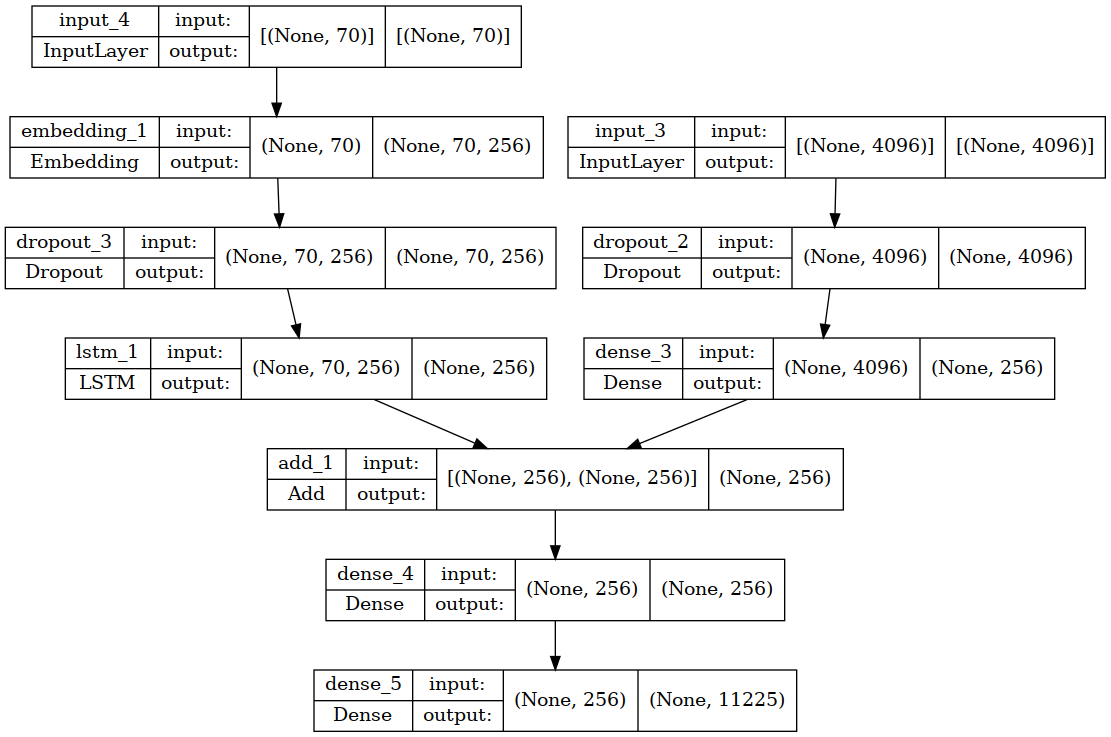

In [29]:
# Encoder
inputs1 = Input(shape=(4096,))
f1 = Dropout(0.4)(inputs1)
f2 = Dense(256, activation='relu')(f1)

inputs2 = Input(shape=(maxCaptionLen,))
s1 = Embedding(vocabSize, 256, mask_zero=True)(inputs2)
s2 = Dropout(0.4)(s1)
s3 = LSTM(256)(s2)


# Decoder
dec1 = add([f2, s3])
dec2 = Dense(256, activation='relu')(dec1)
outputs = Dense(vocabSize, activation='softmax')(dec2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True)

In [30]:
# Train the model
epochs = 15
batchSize = 64
steps = len(trainingMap) // batchSize

for i in range(epochs):
    generator = dataGenerator(trainingMap, features, tokenizer, maxCaptionLen, vocabSize, batchSize)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

2022-08-03 22:26:52.179512: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 262922240 exceeds 10% of free system memory.
2022-08-03 22:26:52.276986: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 262922240 exceeds 10% of free system memory.
2022-08-03 22:26:52.277090: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 262922240 exceeds 10% of free system memory.
2022-08-03 22:26:55.779604: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 262922240 exceeds 10% of free system memory.
2022-08-03 22:26:56.824179: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 262922240 exceeds 10% of free system memory.


: 

In [ ]:
# Save the model
model.save("model.h5")

In [ ]:
modelLoaded = load_model("model.h5")

In [ ]:
def indexToWord(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
def predictCaption(model, image, tokenizer, maxCaptionLength):
    # Add start tag
    inTxt = "startseq"
    for i in range(maxCaptionLength):
        # Encode input sequence
        sequence = tokenizer.texts_to_sequences([inTxt])[0]
        # Pad sequence
        sequence = pad_sequences([sequence], maxCaptionLength)
        # Predict next word
        nxt = model.predict([image, sequence], verbose=0)
        # Get index with high prob
        nxt = np.argmax(nxt)
        # convert index to word
        word = indexToWord(nxt, tokenizer)
        if word is None:
            break
        # Append word ad input for generating next word
        inTxt += " " + word
        # Stop if we are at the end of the string
        if word == "endseq":
            break
    return inTxt

In [ ]:
for key in testMap:
    captions = testMap[key]
    imagePath = os.path.join(IMAGES_PATH, key)
    image = Image.open(imagePath)
    
    print("--------- Actual -----------")
    for caption in captions:
        print(caption)
    pred = predictCaption(model, features[key], tokenizer, maxCaptionLen)
    print("--------- Predicted --------------")
    print(pred)
    
    plt.imshow(image)

In [ ]:
# Validate using test data
actual, predicted = list(), list()
for key in tqdm(testMap):
    captions = testMap[key]
    pred = predictCaption(model, features[key], tokenizer, maxCaptionLen)
    # Split pred into words
    pred = pred.split()
    # Split real captions into words
    realCaptions = [caption.split() for caption in captions]
    
    # Append predictions and real captions to the respective list
    predicted.append(pred)
    actual.append(realCaptions)

# Calculate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))